In [1]:
! unzip images.zip
! unzip images_test.zip

Archive:  images.zip
  inflating: images/494_Led Zeppelin II (Remaster).jpg  
  inflating: images/458_Houses of the Holy (Deluxe Edition).jpg  
  inflating: images/232_Legend Remixed.jpg  
  inflating: images/169_Led Zeppelin III (Remaster).jpg  
  inflating: images/222_Physical Graffiti (Deluxe Edition).jpg  
  inflating: images/271_Houses of the Holy (Remaster).jpg  
  inflating: images/243_Led Zeppelin IV (Deluxe Edition).jpg  
  inflating: images/60_Adios Bahamas.jpg  
  inflating: images/138_Led Zeppelin IV (Remaster).jpg  
  inflating: images/479_Presence (Remaster).jpg  
  inflating: images/175_The Song Remains the Same (Remaster).jpg  
  inflating: images/77_Physical Graffiti (Remaster).jpg  
  inflating: images/57_In Through the out Door (Remaster).jpg  
  inflating: images/365_Coda (Deluxe Edition).jpg  
  inflating: images/146_Presence (Deluxe Edition).jpg  
  inflating: images/227_Led Zeppelin III (Deluxe Edition).jpg  
  inflating: images/27_Exodus (Deluxe Edition).jpg  
 

In [2]:
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from google.colab import files

In [3]:
img_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

In [4]:
print(len(os.listdir('images/')))
for file in tqdm(os.listdir('images/')):
    img = cv2.imread(os.path.join('images/', file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in img_gen.flow(img, batch_size=1, save_to_dir='images/', save_prefix=file.split('.')[0], save_format='jpeg'):
        i += 1
        if i >= 39:
            break
print(len(os.listdir('images/')))

500


100%|██████████| 500/500 [31:09<00:00,  3.74s/it]

19966


In [5]:
os.makedirs('train_set/', exist_ok=True)
os.makedirs('test_set/test', exist_ok=True)

for filename in os.listdir('images'):
  target_directory = os.path.join('train_set/', filename[0:filename.find('_')])
  os.makedirs(target_directory, exist_ok=True)
  image_path = os.path.join('images/', filename)
  shutil.move(image_path, target_directory)

for filename in os.listdir('images_test'):
  shutil.move(os.path.join('images_test/', filename), 'test_set/test')

In [6]:
! zip -r train_set.zip train_set
! zip -r test_set.zip test_set

Streaming output truncated to the last 5000 lines.
  adding: train_set/400/ (stored 0%)
  adding: train_set/400/400_Set Fire to the Rain_0_6270.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_2683.jpeg (deflated 0%)
  adding: train_set/400/400_Set Fire to the Rain_0_3445.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_1512.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_952.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_9037.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_9493.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_662.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain.jpg (deflated 0%)
  adding: train_set/400/400_Set Fire to the Rain_0_6791.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_1518.jpeg (deflated 1%)
  adding: train_set/400/400_Set Fire to the Rain_0_186.jpeg (deflated 1%)
  adding: train_set/400

In [7]:
files.download('train_set.zip')
files.download('test_set.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

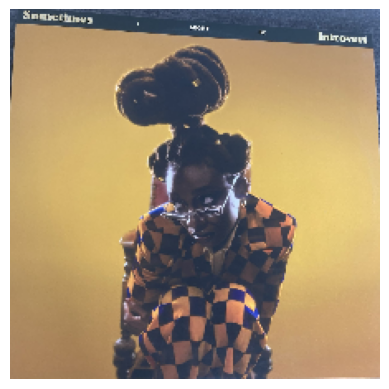

In [8]:
img = cv2.imread('test_set/test/121_Screenshot 2024-02-23 at 11.27.29.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()

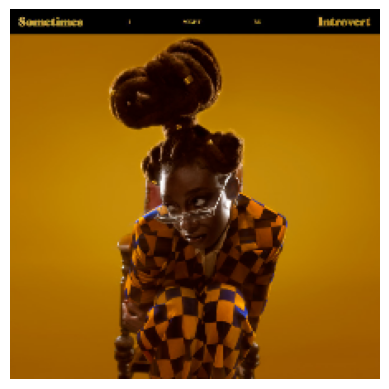

In [9]:
img = cv2.imread('train_set/121/121_Sometimes I Might Be Introvert.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
train_img_gen = ImageDataGenerator(validation_split=0.2)

train_data_gen = train_img_gen.flow_from_directory('train_set/', target_size=(224, 224), batch_size=64, class_mode='categorical', subset='training')
val_data_gen = train_img_gen.flow_from_directory('train_set/', target_size=(224, 224), batch_size=64, class_mode='categorical', subset='validation')


Found 15997 images belonging to 500 classes.
Found 3969 images belonging to 500 classes.


In [11]:
deep_conv_net_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classes=500
)

deep_conv_net_model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [12]:
deep_conv_net_model.trainable = False
deep_conv_net_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [13]:
model = Sequential([deep_conv_net_model, Dense(1024, activation='relu'), Dense(500, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 500)               512500    
                                                                 
Total params: 26198388 (99.94 MB)
Trainable params: 2610676 (9.96 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=20,
                    steps_per_epoch=len(train_data_gen),
                    validation_steps=len(val_data_gen),
                    callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 70s 253ms/step - loss: 0.7135 - accuracy: 0.8960 - val_loss: 0.0697 - val_accuracy: 0.9844
Epoch 2/20
250/250 [==============================] - 61s 242ms/step - loss: 0.0507 - accuracy: 0.9851 - val_loss: 0.0691 - val_accuracy: 0.9836
Epoch 3/20
250/250 [==============================] - 62s 246ms/step - loss: 0.0373 - accuracy: 0.9862 - val_loss: 0.0383 - val_accuracy: 0.9839
Epoch 4/20
250/250 [==============================] - 61s 242ms/step - loss: 0.0318 - accuracy: 0.9851 - val_loss: 0.0409 - val_accuracy: 0.9846
Epoch 5/20
250/250 [==============================] - 62s 249ms/step - loss: 0.0312 - accuracy: 0.9862 - val_loss: 0.0386 - val_accuracy: 0.9851
Epoch 6/20
250/250 [==============================] - 62s 249ms/step - loss: 0.0291 - accuracy: 0.9859 - val_loss: 0.0293 - val_accuracy: 0.9854
Epoch 7/20
250/250 [==============================] - 60s 240ms/step - loss: 0.0273 - accuracy: 0.9869 - val_loss: 0.0318 - val_ac

In [15]:
model.save('ResNet50_model')
print(os.listdir('ResNet50_model'))

['variables', 'saved_model.pb', 'fingerprint.pb', 'keras_metadata.pb', 'assets']


In [16]:
test_img_gen = ImageDataGenerator()
test_data_gen = test_img_gen.flow_from_directory('test_set/', target_size=(224, 224), class_mode=None, shuffle=False)

Found 45 images belonging to 1 classes.


In [17]:
predictions = model.predict(test_data_gen)

2/2 [==============================] - 2s 434ms/step


In [18]:
predicted_labels = np.argmax(predictions, axis=1)
display(predicted_labels.shape)

true_labels = np.array([filename[5:filename.find('_')] for filename in test_data_gen.filenames])
true_labels = np.array( [train_data_gen.class_indices[x] for x in true_labels])
display(true_labels.shape)

print(f'The model accuracy score: {metrics.accuracy_score(true_labels, predicted_labels):.2f}')

(45,)

(45,)

The model accuracy score: 0.89


In [19]:
display(true_labels)
display(predicted_labels)

for filename, true_label, predicted_label in zip(test_data_gen.filenames, true_labels, predicted_labels):
    print(f"{filename}: {true_label} {predicted_label}")

array([ 25,  25,  25,  25,  25,  40,  40,  40,  40,  40,  80,  80,  80,
        80,  80, 110, 110, 110, 110, 110, 117, 117, 117, 117, 117, 201,
       201, 201, 201, 201, 224, 224, 224, 224, 224, 396, 396, 396, 396,
       396, 487, 487, 487, 487, 487])

array([ 25,  25,  25,  25,  25,  40,  40,  40,  40,  40, 148, 148, 148,
       148, 148, 110, 110, 110, 110, 110, 117, 117, 117, 117, 117, 201,
       201, 201, 201, 201, 224, 224, 224, 224, 224, 396, 396, 396, 396,
       396, 487, 487, 487, 487, 487])

test/121_Screenshot 2024-02-23 at 11.27.29.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.34.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.39.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.45.jpg: 25 25
test/121_Screenshot 2024-02-23 at 11.27.52.jpg: 25 25
test/135_Screenshot 2024-02-21 at 19.06.59.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.05.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.10.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.15.jpg: 40 40
test/135_Screenshot 2024-02-21 at 19.07.21.jpg: 40 40
test/171_Screenshot 2024-02-23 at 11.28.13.jpg: 80 148
test/171_Screenshot 2024-02-23 at 11.28.20.jpg: 80 148
test/171_Screenshot 2024-02-23 at 11.28.51.jpg: 80 148
test/171_Screenshot 2024-02-23 at 11.29.00.jpg: 80 148
test/171_Screenshot 2024-02-23 at 11.29.08.jpg: 80 148
test/199_Screenshot 2024-02-23 at 11.25.43.jpg: 110 110
test/199_Screenshot 2024-02-23 at 11.25.47.jpg: 110 110
test/199_Screenshot 2024-02-23 at 11.25.53.jpg: 110 110
test/199_Screensh

In [20]:
! zip -r ResNet50_model.zip ResNet50_model

  adding: ResNet50_model/ (stored 0%)
  adding: ResNet50_model/variables/ (stored 0%)
  adding: ResNet50_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: ResNet50_model/variables/variables.index (deflated 78%)
  adding: ResNet50_model/saved_model.pb (deflated 91%)
  adding: ResNet50_model/fingerprint.pb (stored 0%)
  adding: ResNet50_model/keras_metadata.pb (deflated 96%)
  adding: ResNet50_model/assets/ (stored 0%)


In [21]:
files.download('ResNet50_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
files.download('train_set.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>